# SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [169]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [170]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

In [173]:
def running_mean(z, M):
    mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

## Part 1 : backward exponential smoothing

In [174]:
N = 300
X, z = generate_trajectory(28**2, 97**2, N, 10)
x_f = exp_mean(z, alpha_opt(28**2,97**2))
x_b = backward_exp_mean(x_f, alpha_opt(28**2,97**2))

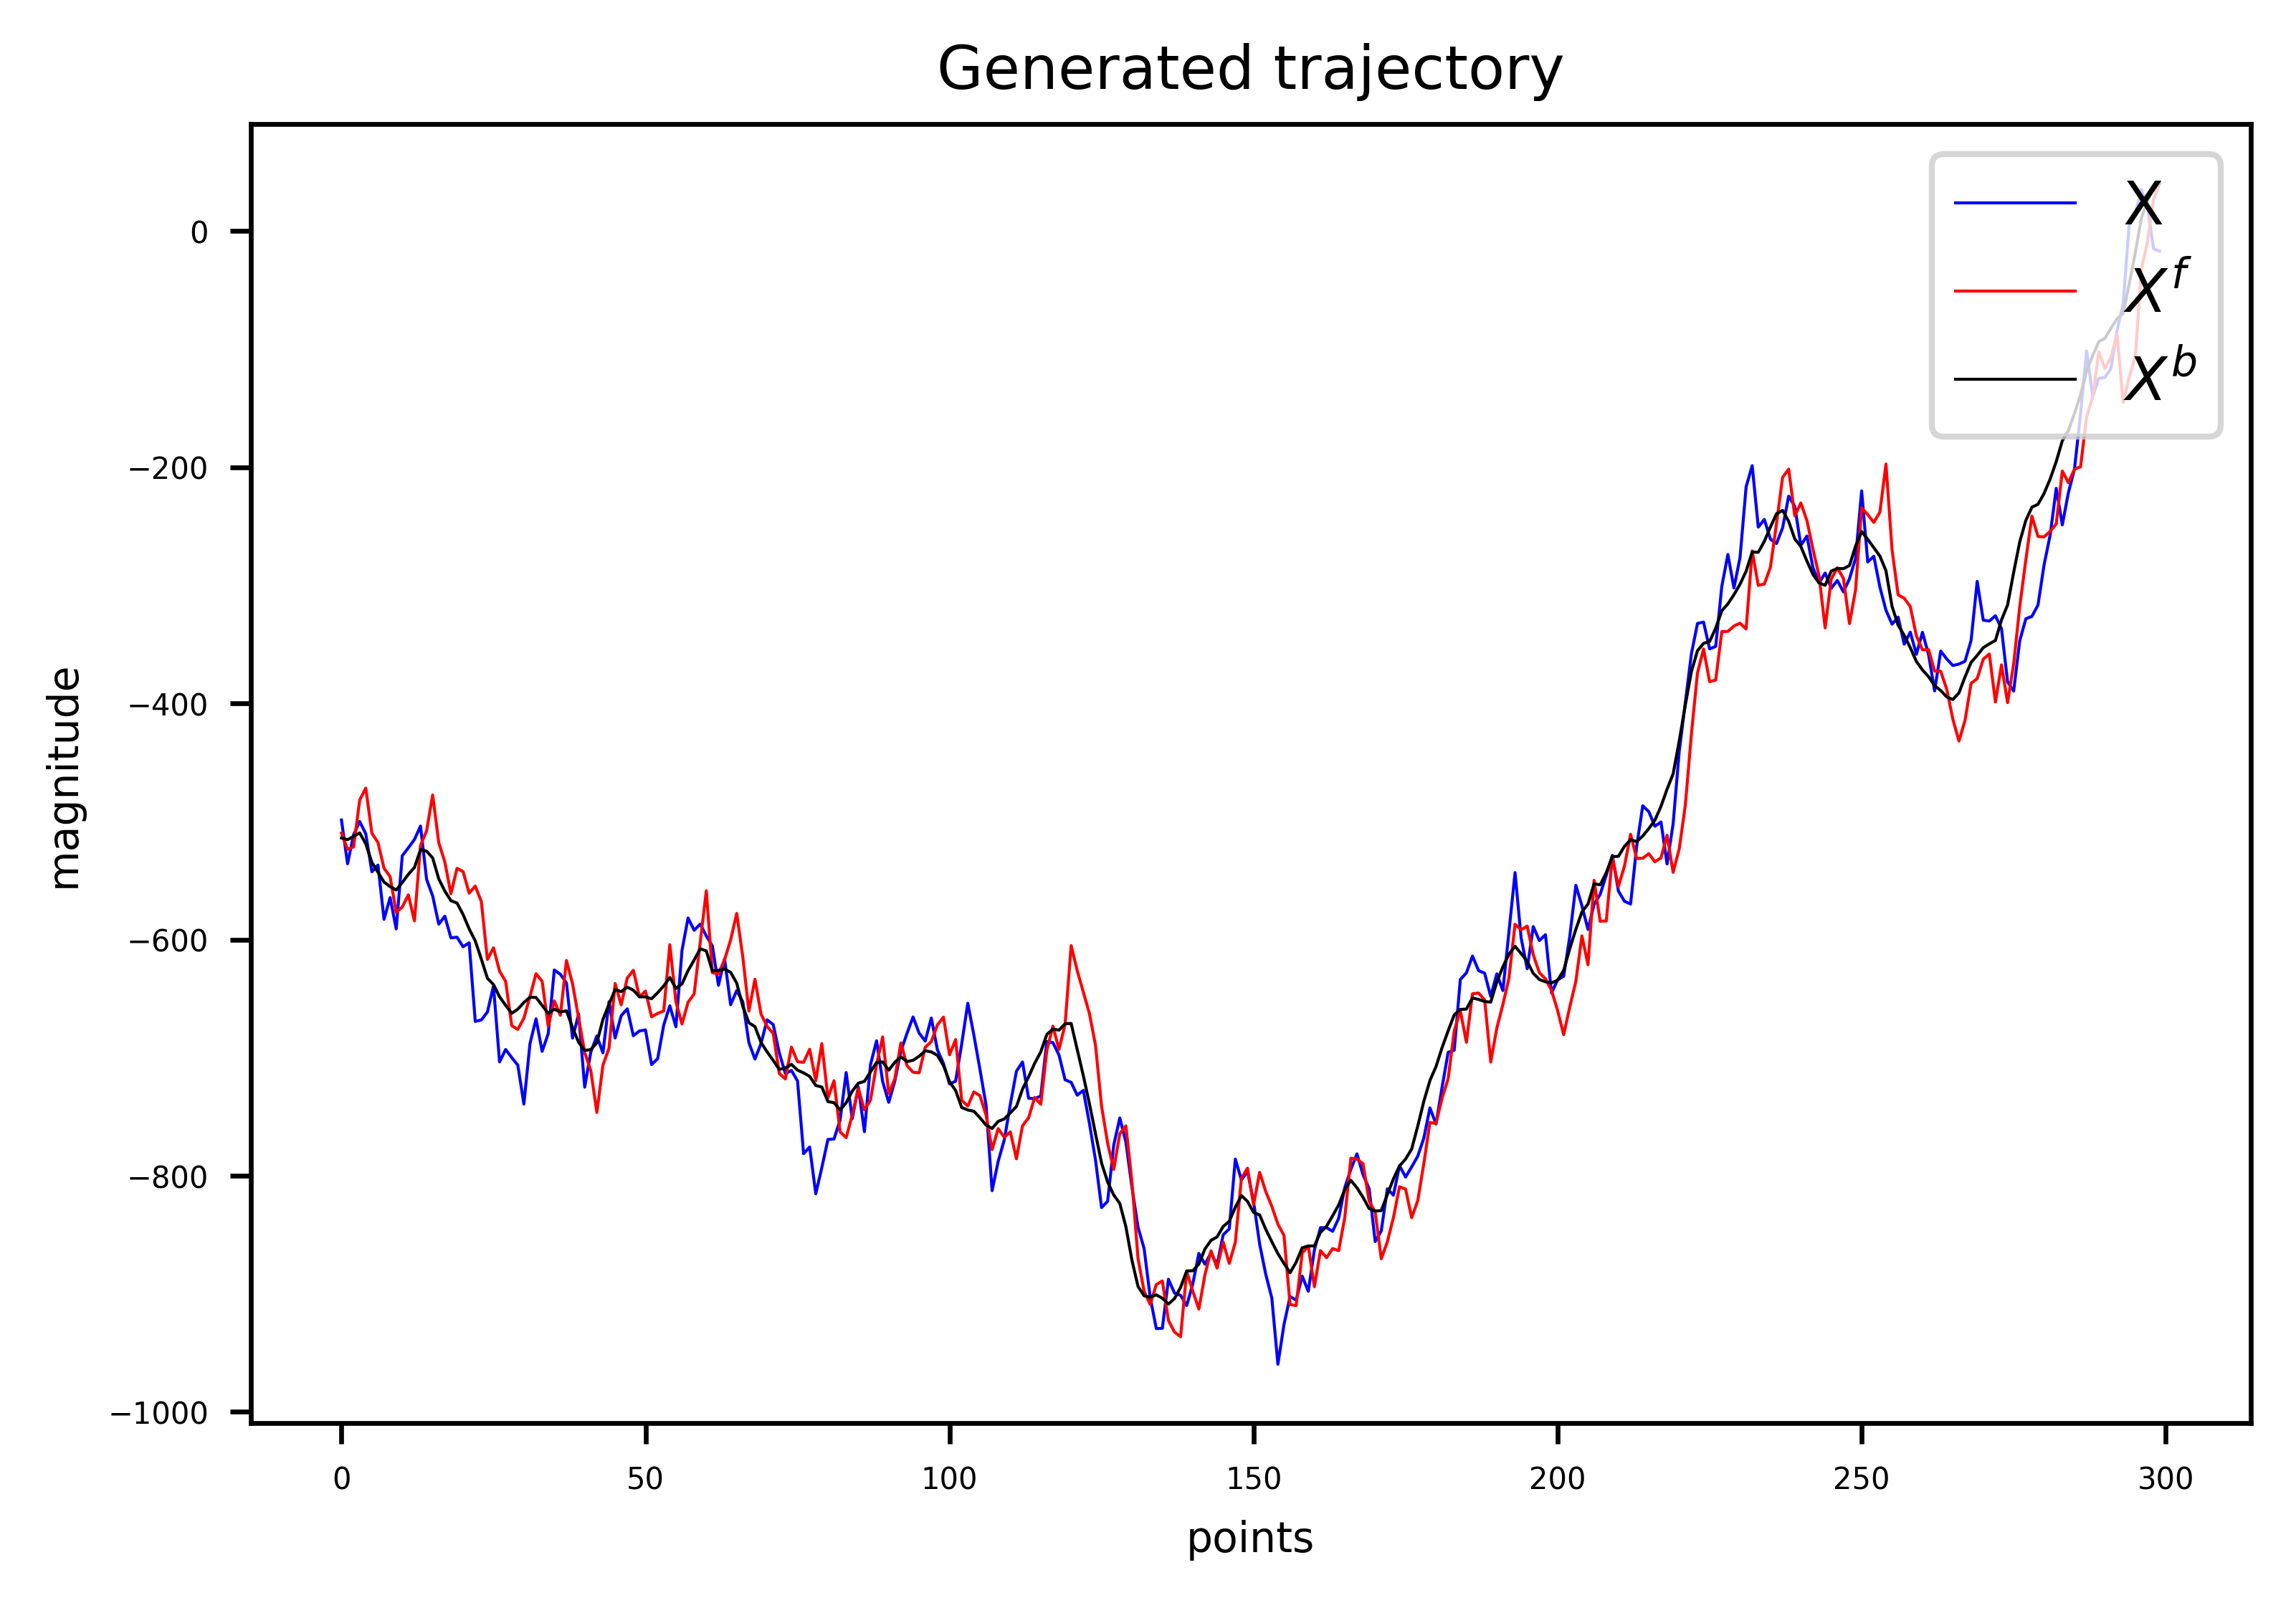

In [175]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
#ax.plot(range(N),z,'g', label = 'z', linewidth = 0.5 )
ax.plot(range(N),X,'b', label = 'X', linewidth = 0.5 )
ax.plot(range(N),x_f,'r', label = r'$X^f$', linewidth = 0.5 )
ax.plot(range(N),x_b,'black', label = r'$X^b$', linewidth = 0.5 )
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7)
ax.legend(loc = 'upper right', fontsize = 10);

### Backward exponential mean helps to correct shift of forward exponential mean but big differences of magnitude remain

## Part 2: Drawbacks of running mean

## First trajectory

In [176]:
N = 300
sigma_a_2 = 10
sigma_n_2 = 500
a = np.random.normal(0, sigma_a_2 ** 0.5, N)
t = 0.1
x_0 = 5
v_0 = 0
v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
x = np.ones(N) * x_0 + (v_1 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)

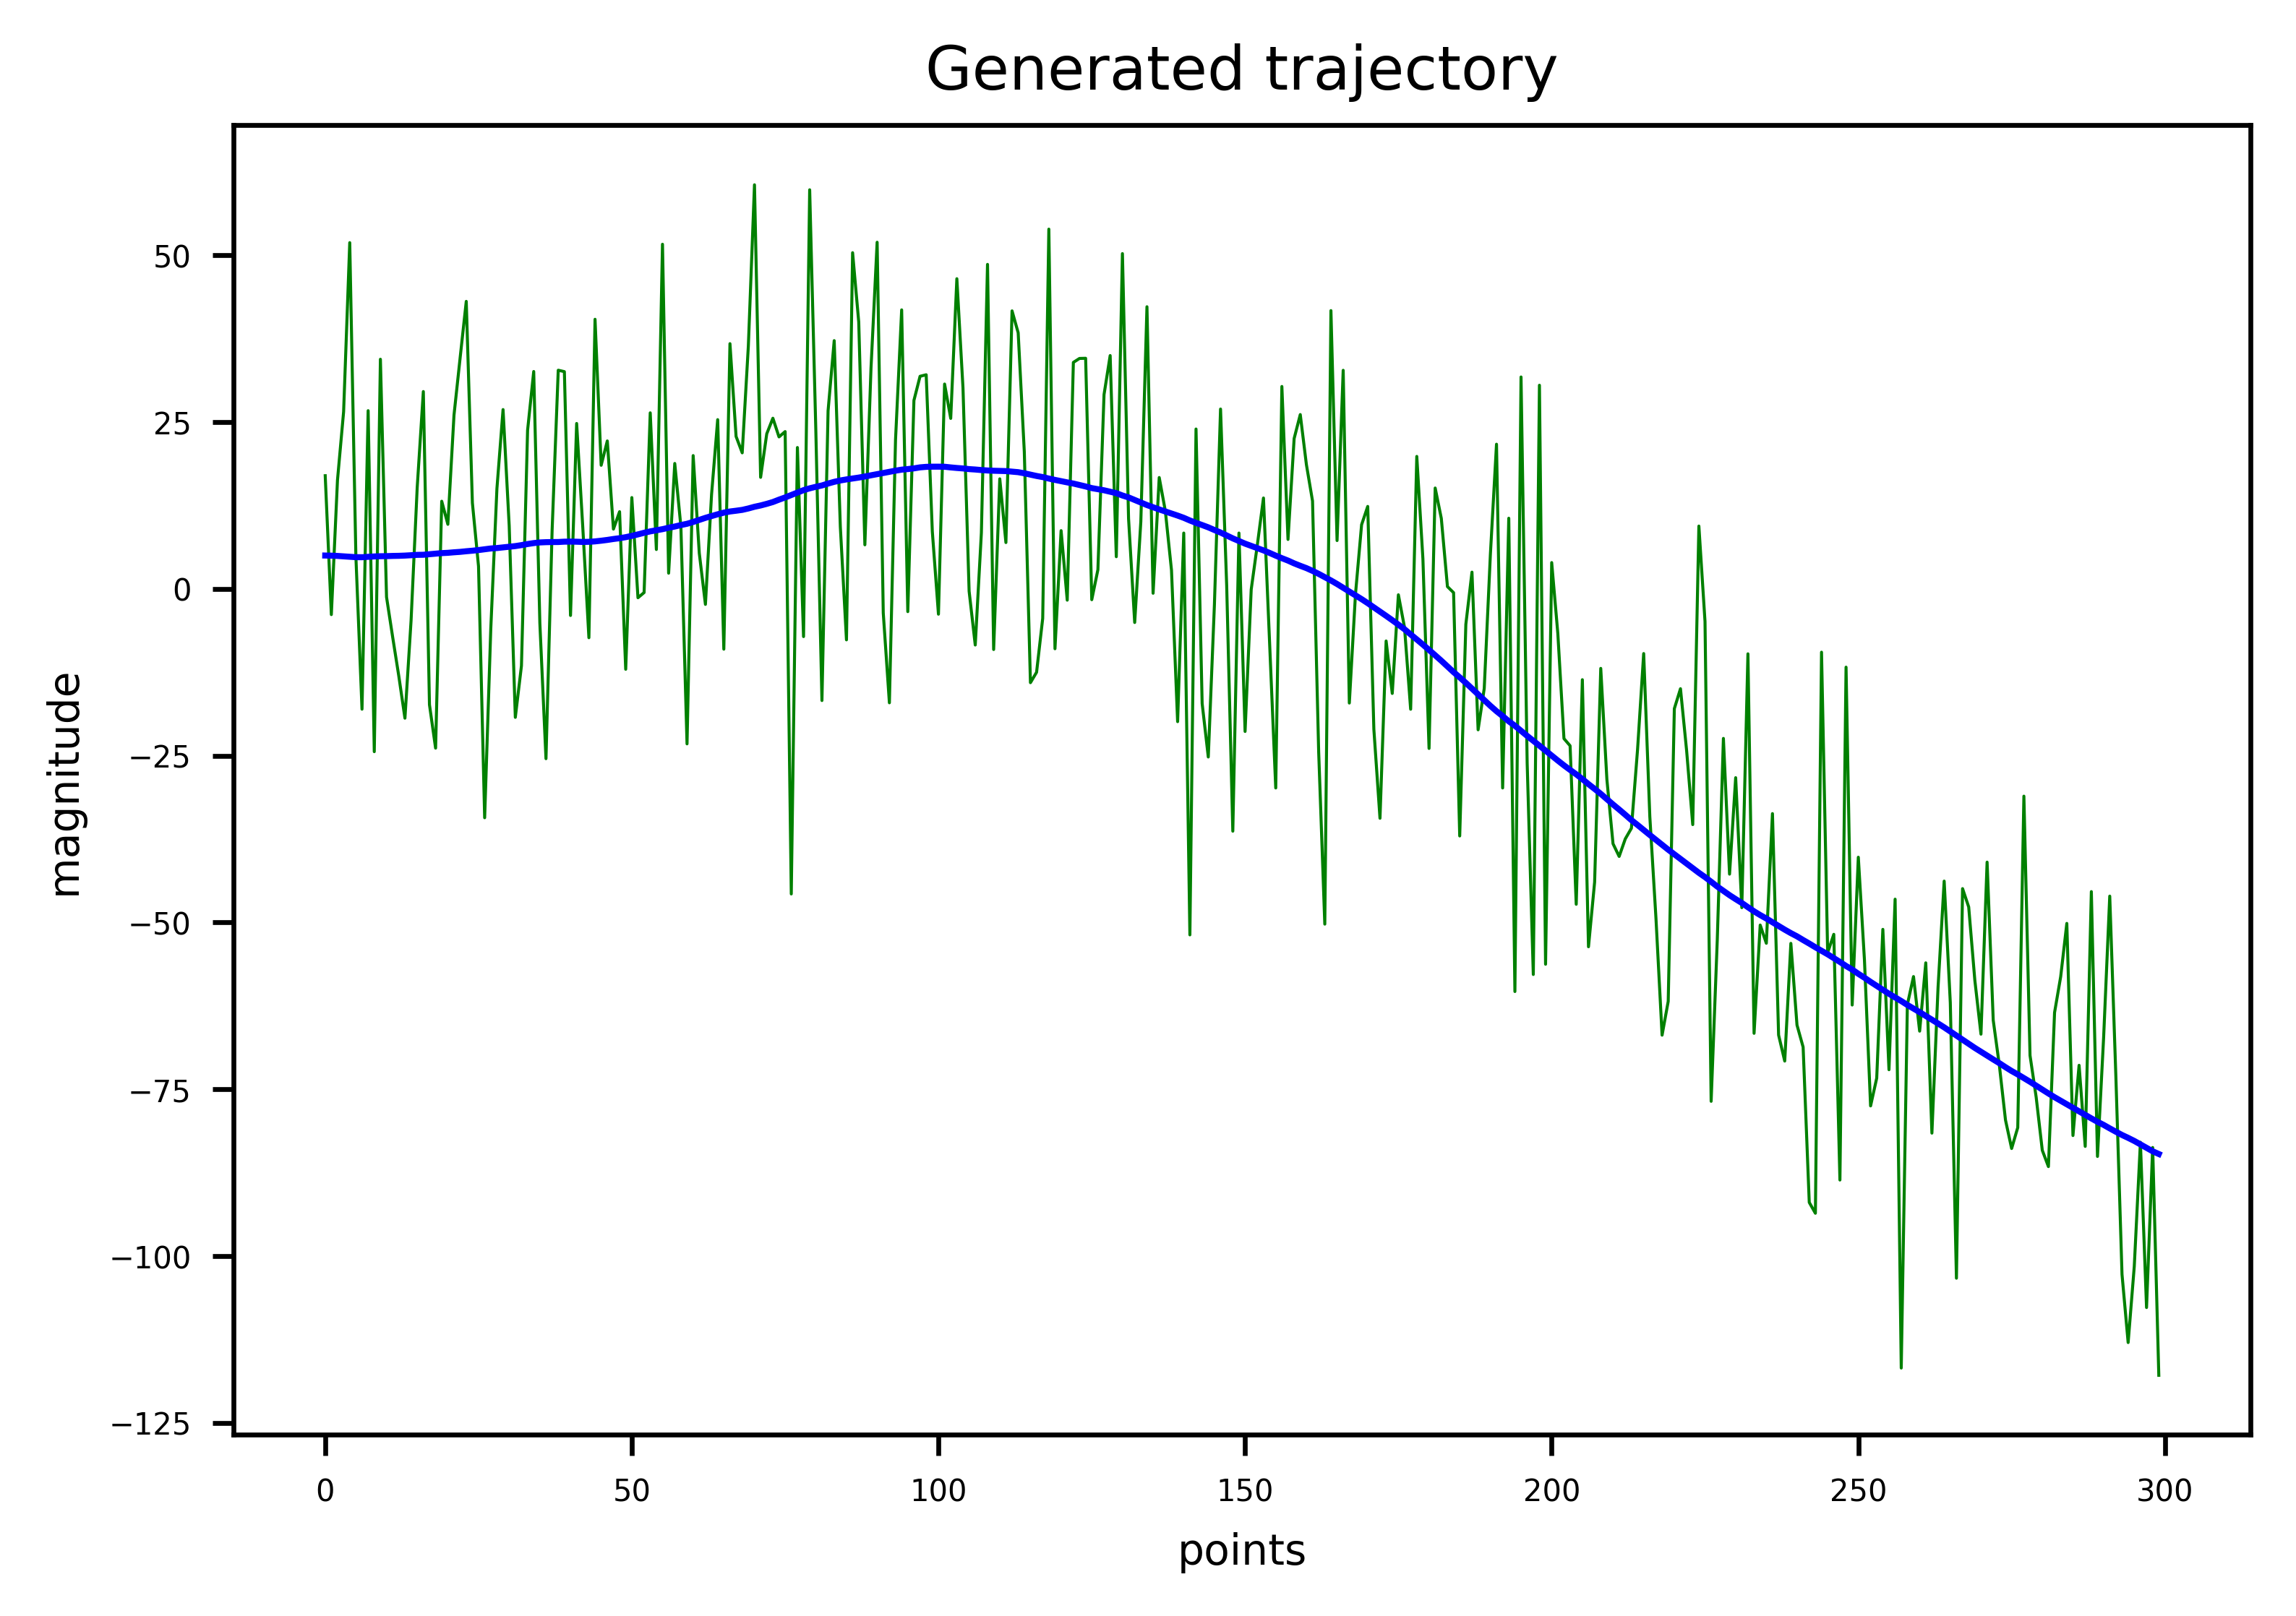

In [177]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = 'z', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = 'X', linewidth = 1 )
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

### Calculating coefficiens $I_d$ and $I_v$ for running mean and exp for determination of appropriate $\alpha$

In [ ]:
def Id(z, x):
    return np.sum((z-x)**2)

def Iv(x):
    return np.sum((np.roll(x,-2) - 2 * np.roll(x,-1) + x)[:-2]**2)

In [156]:
alphas = np.arange(0.01, 0.2, 0.001)
Id_exp = []
Id_mean = []
Iv_exp = []
Iv_mean = []
for alpha in alphas:
    x_mean = running_mean(z, M_opt(alpha))
    x_exp = exp_mean(z, alpha)
    Id_exp.append(Id(z, x_exp))
    Id_mean.append(Id(z, x_mean))
    Iv_exp.append(Iv(x_exp))
    Iv_mean.append(Iv(x_mean))  

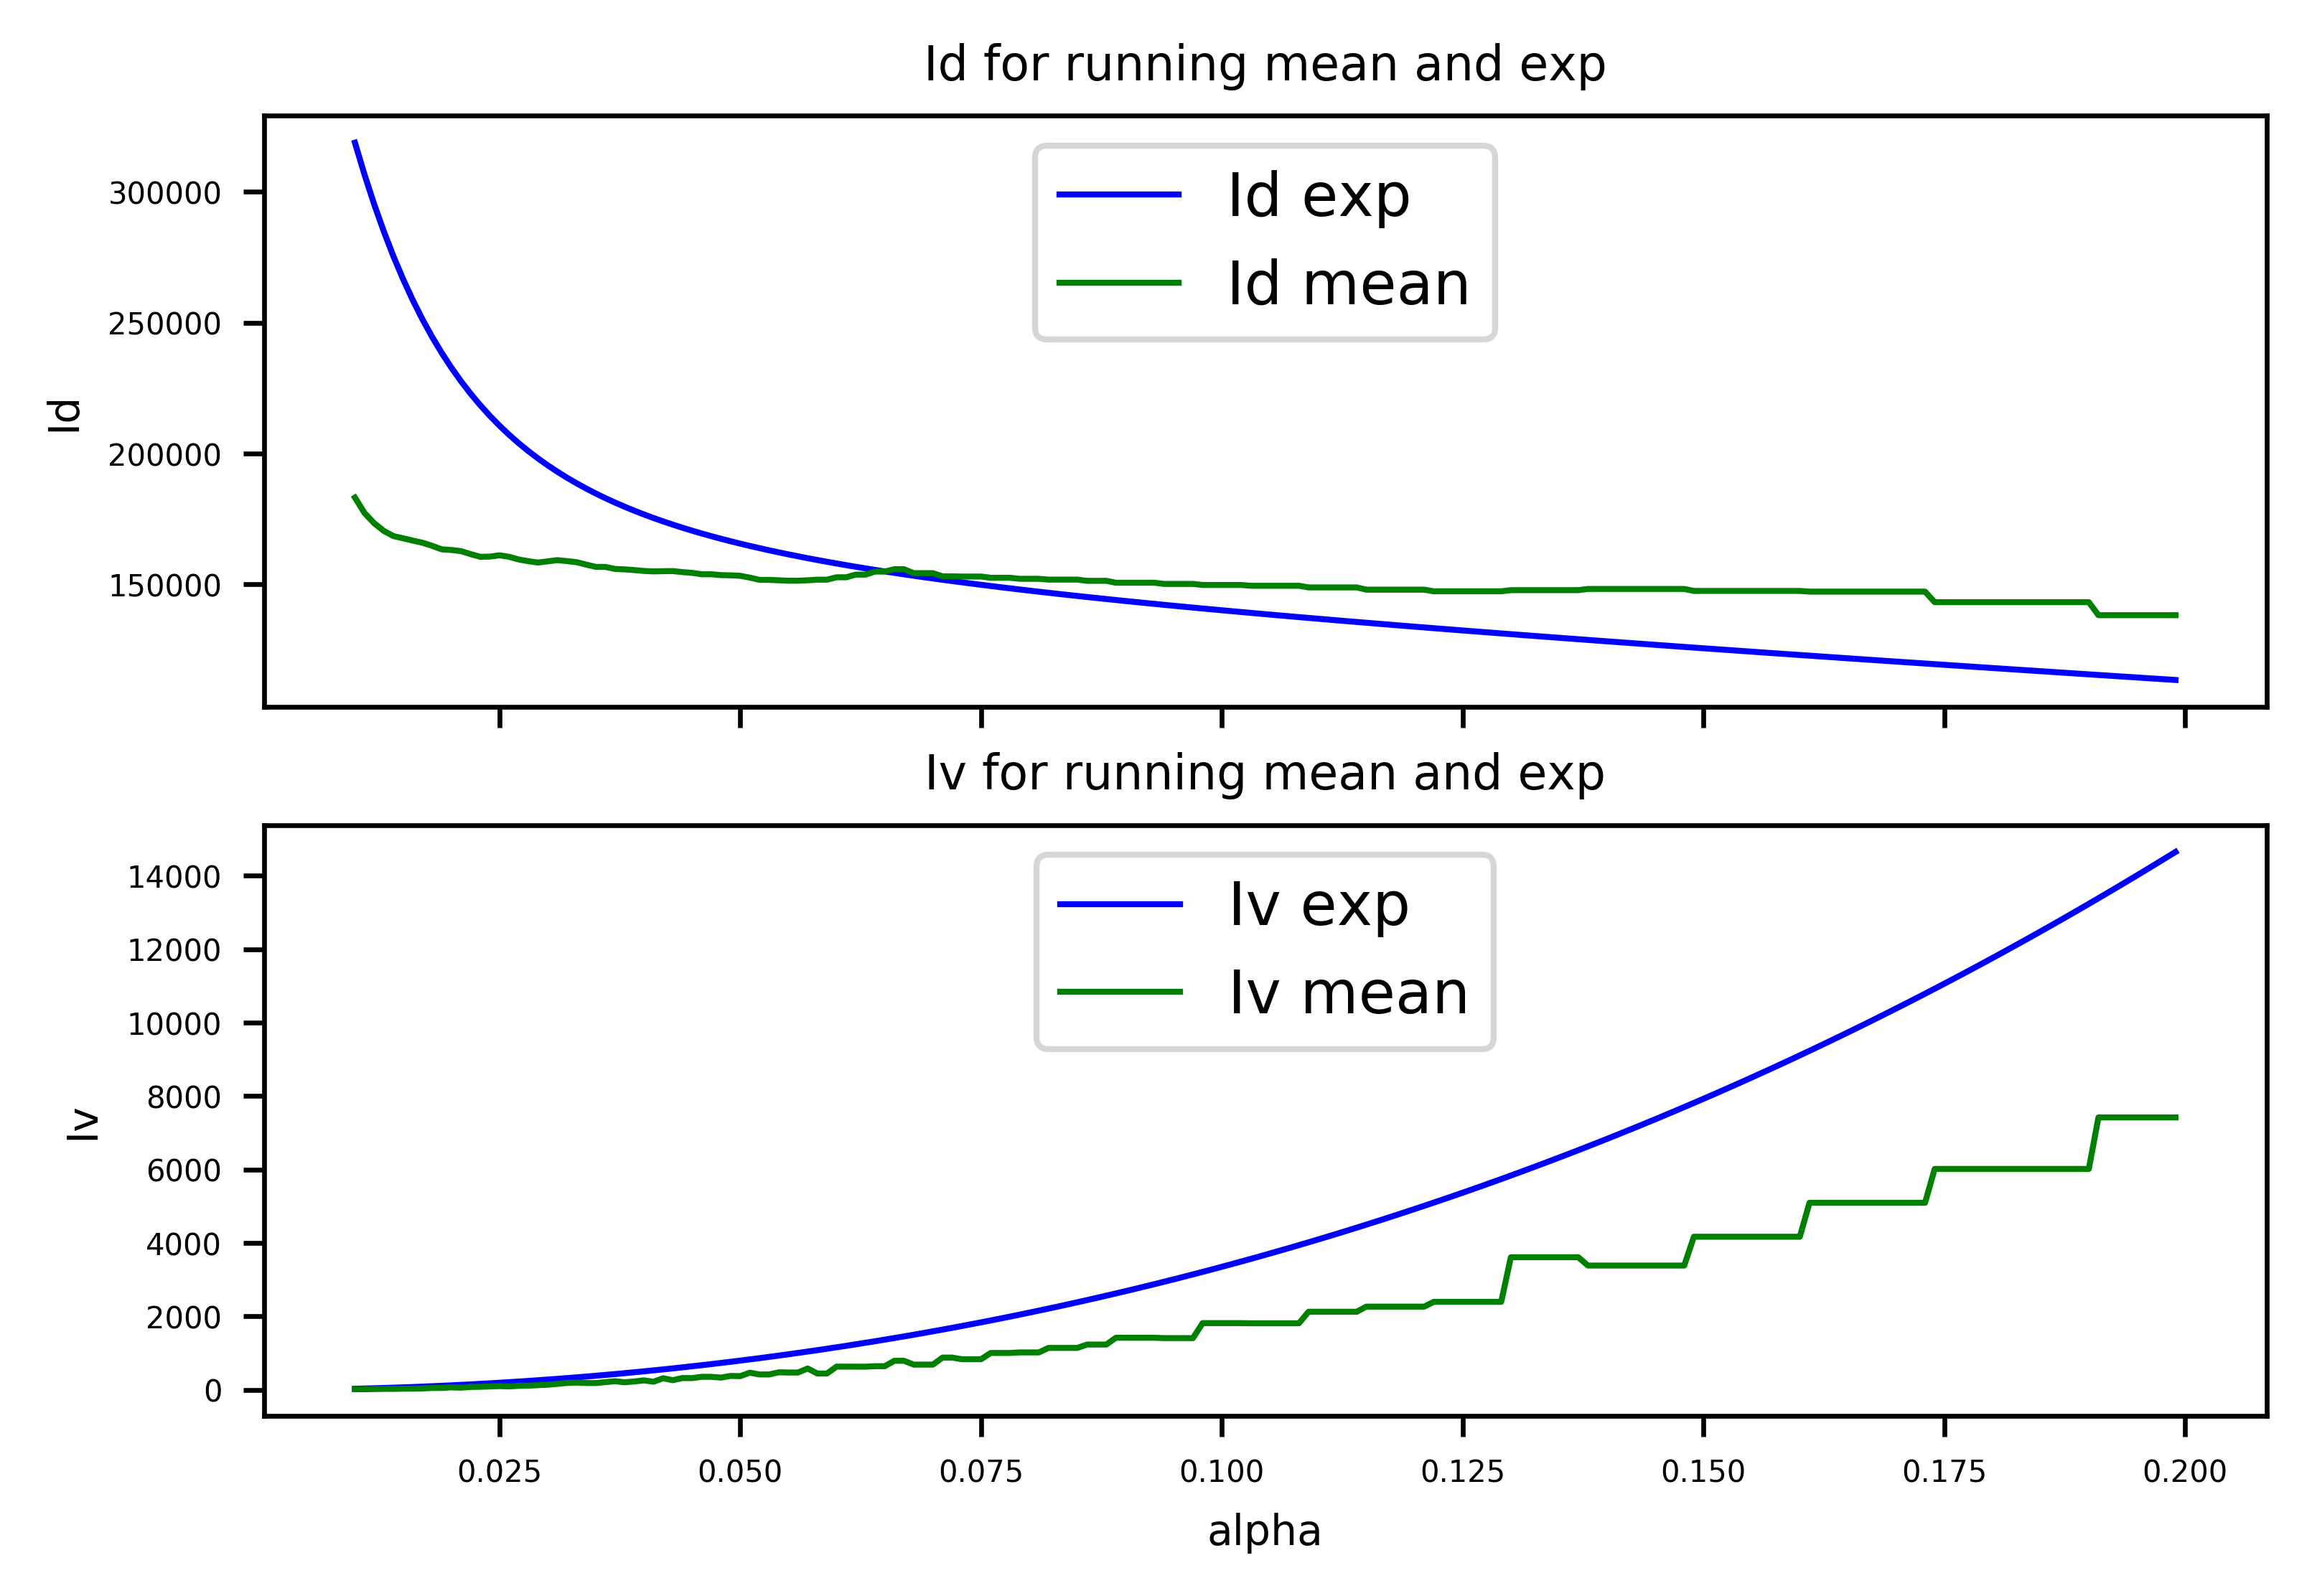

In [157]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex=True)
ax[0].set_title('Id for running mean and exp', fontsize = 8)
ax[0].plot(alphas, Id_exp,'b', label = 'Id exp', linewidth = 1)
ax[0].plot(alphas, Id_mean,'g', label = 'Id mean', linewidth = 1)
#ax[0].set_xlabel('alpha', fontsize = 7)
ax[0].set_ylabel('Id', fontsize = 7)
ax[0].legend(loc="upper center", fontsize=10);

ax[1].set_title('Iv for running mean and exp', fontsize = 8)
ax[1].plot(alphas, Iv_exp,'b', label = 'Iv exp', linewidth = 1)
ax[1].plot(alphas, Iv_mean,'g', label = 'Iv mean', linewidth = 1)
ax[1].set_xlabel('alpha', fontsize = 7)
ax[1].set_ylabel('Iv', fontsize = 7)
ax[1].legend(loc="upper center", fontsize=10);

### optimal $\alpha$ is 0.075 

In [179]:
alpha = 0.075
x_mean = running_mean(z, M_opt(alpha))
x_exp = exp_mean(z, alpha)

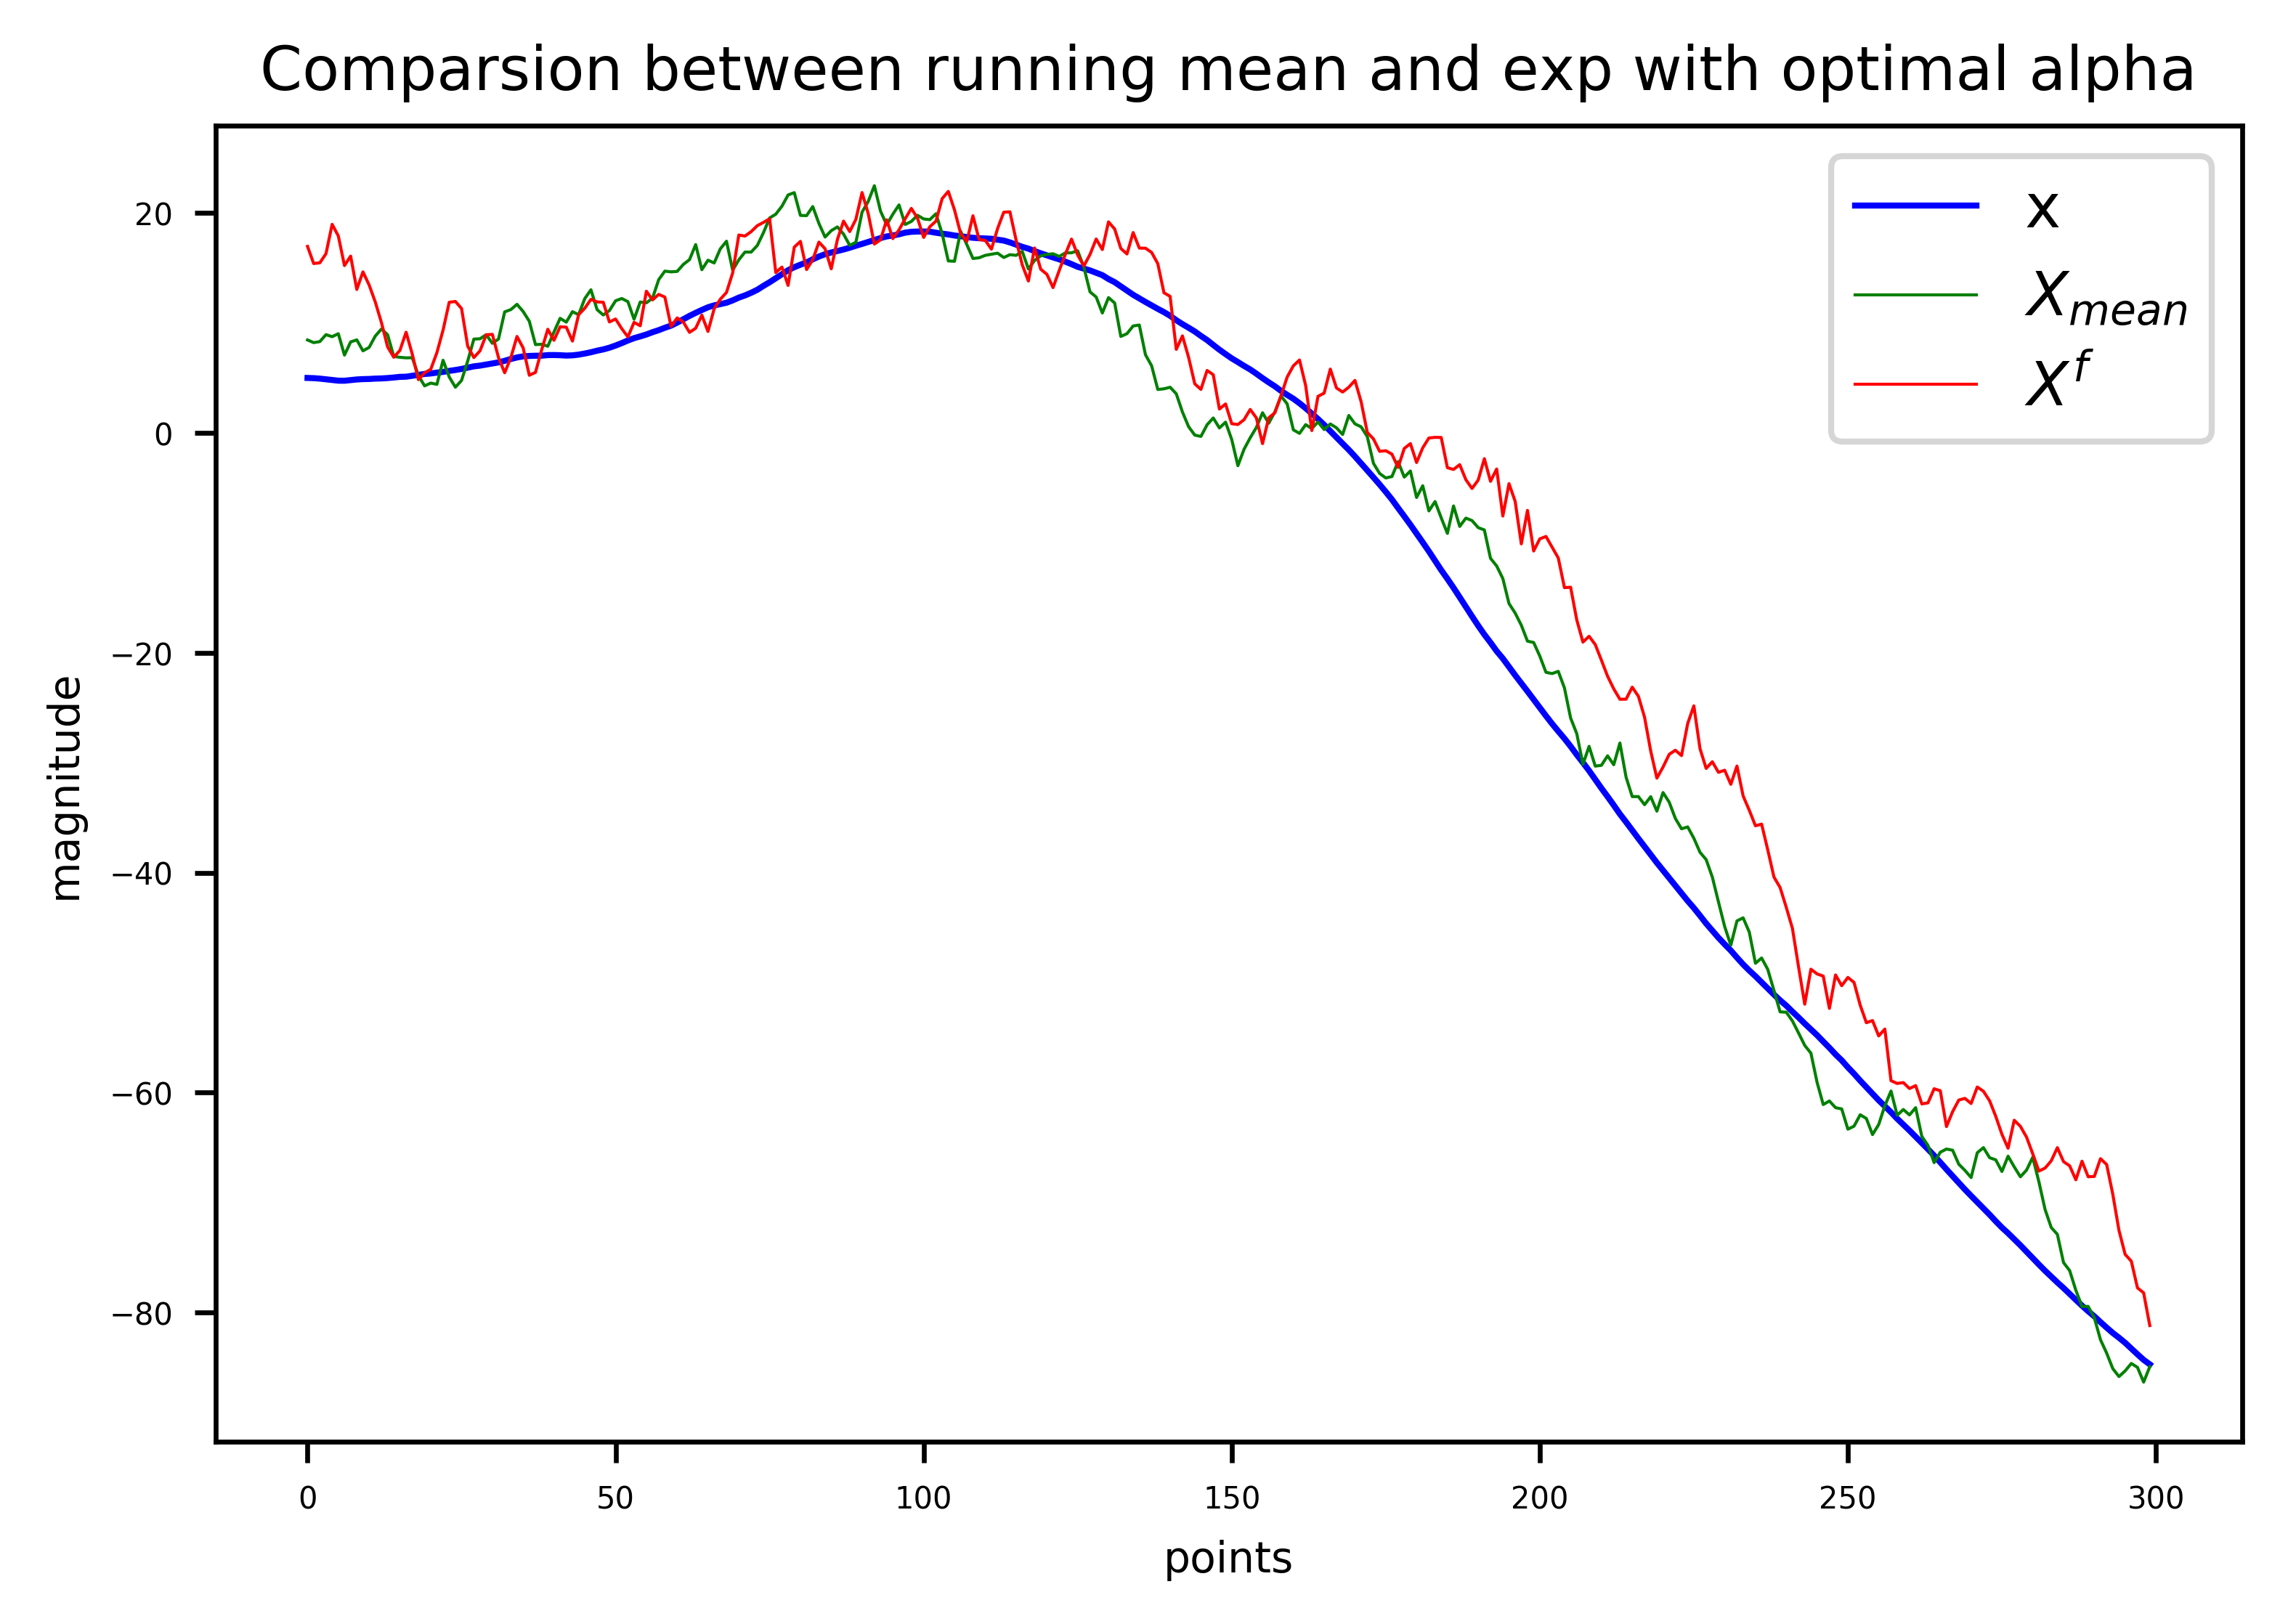

In [181]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Comparsion between running mean and exp with optimal alpha', fontsize = 10)
ax.plot(range(N), x,'b', label = 'x', linewidth = 1)
#ax.plot(range(int(M/2), N - int(M/2)), x_mean[int(M/2): -int(M/2)],'g', label = r'$X_M$', linewidth = 0.5)
ax.plot(range(N), running_mean(z, M_opt(alpha)),'g', label = r'$X_{mean}$', linewidth = 0.5)
ax.plot(range(N), x_exp,'r', label = r'$X^f$', linewidth = 0.5)
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7)
ax.legend(loc="upper right", fontsize=10);

## Second trajectory

In [160]:
N = 200
T = 32
omega = 2 * np.pi / T
sigma_w = 0.08
A_0 = 1
w = np.random.normal(0, sigma_w, N)
A = np.ones(N) * A_0 + w.dot(np.triu(np.ones((N, N)), 1))
x = A * np.sin(omega * np.arange(0, N, 1) + 3)
sigma_n_2 = 0.05
z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)

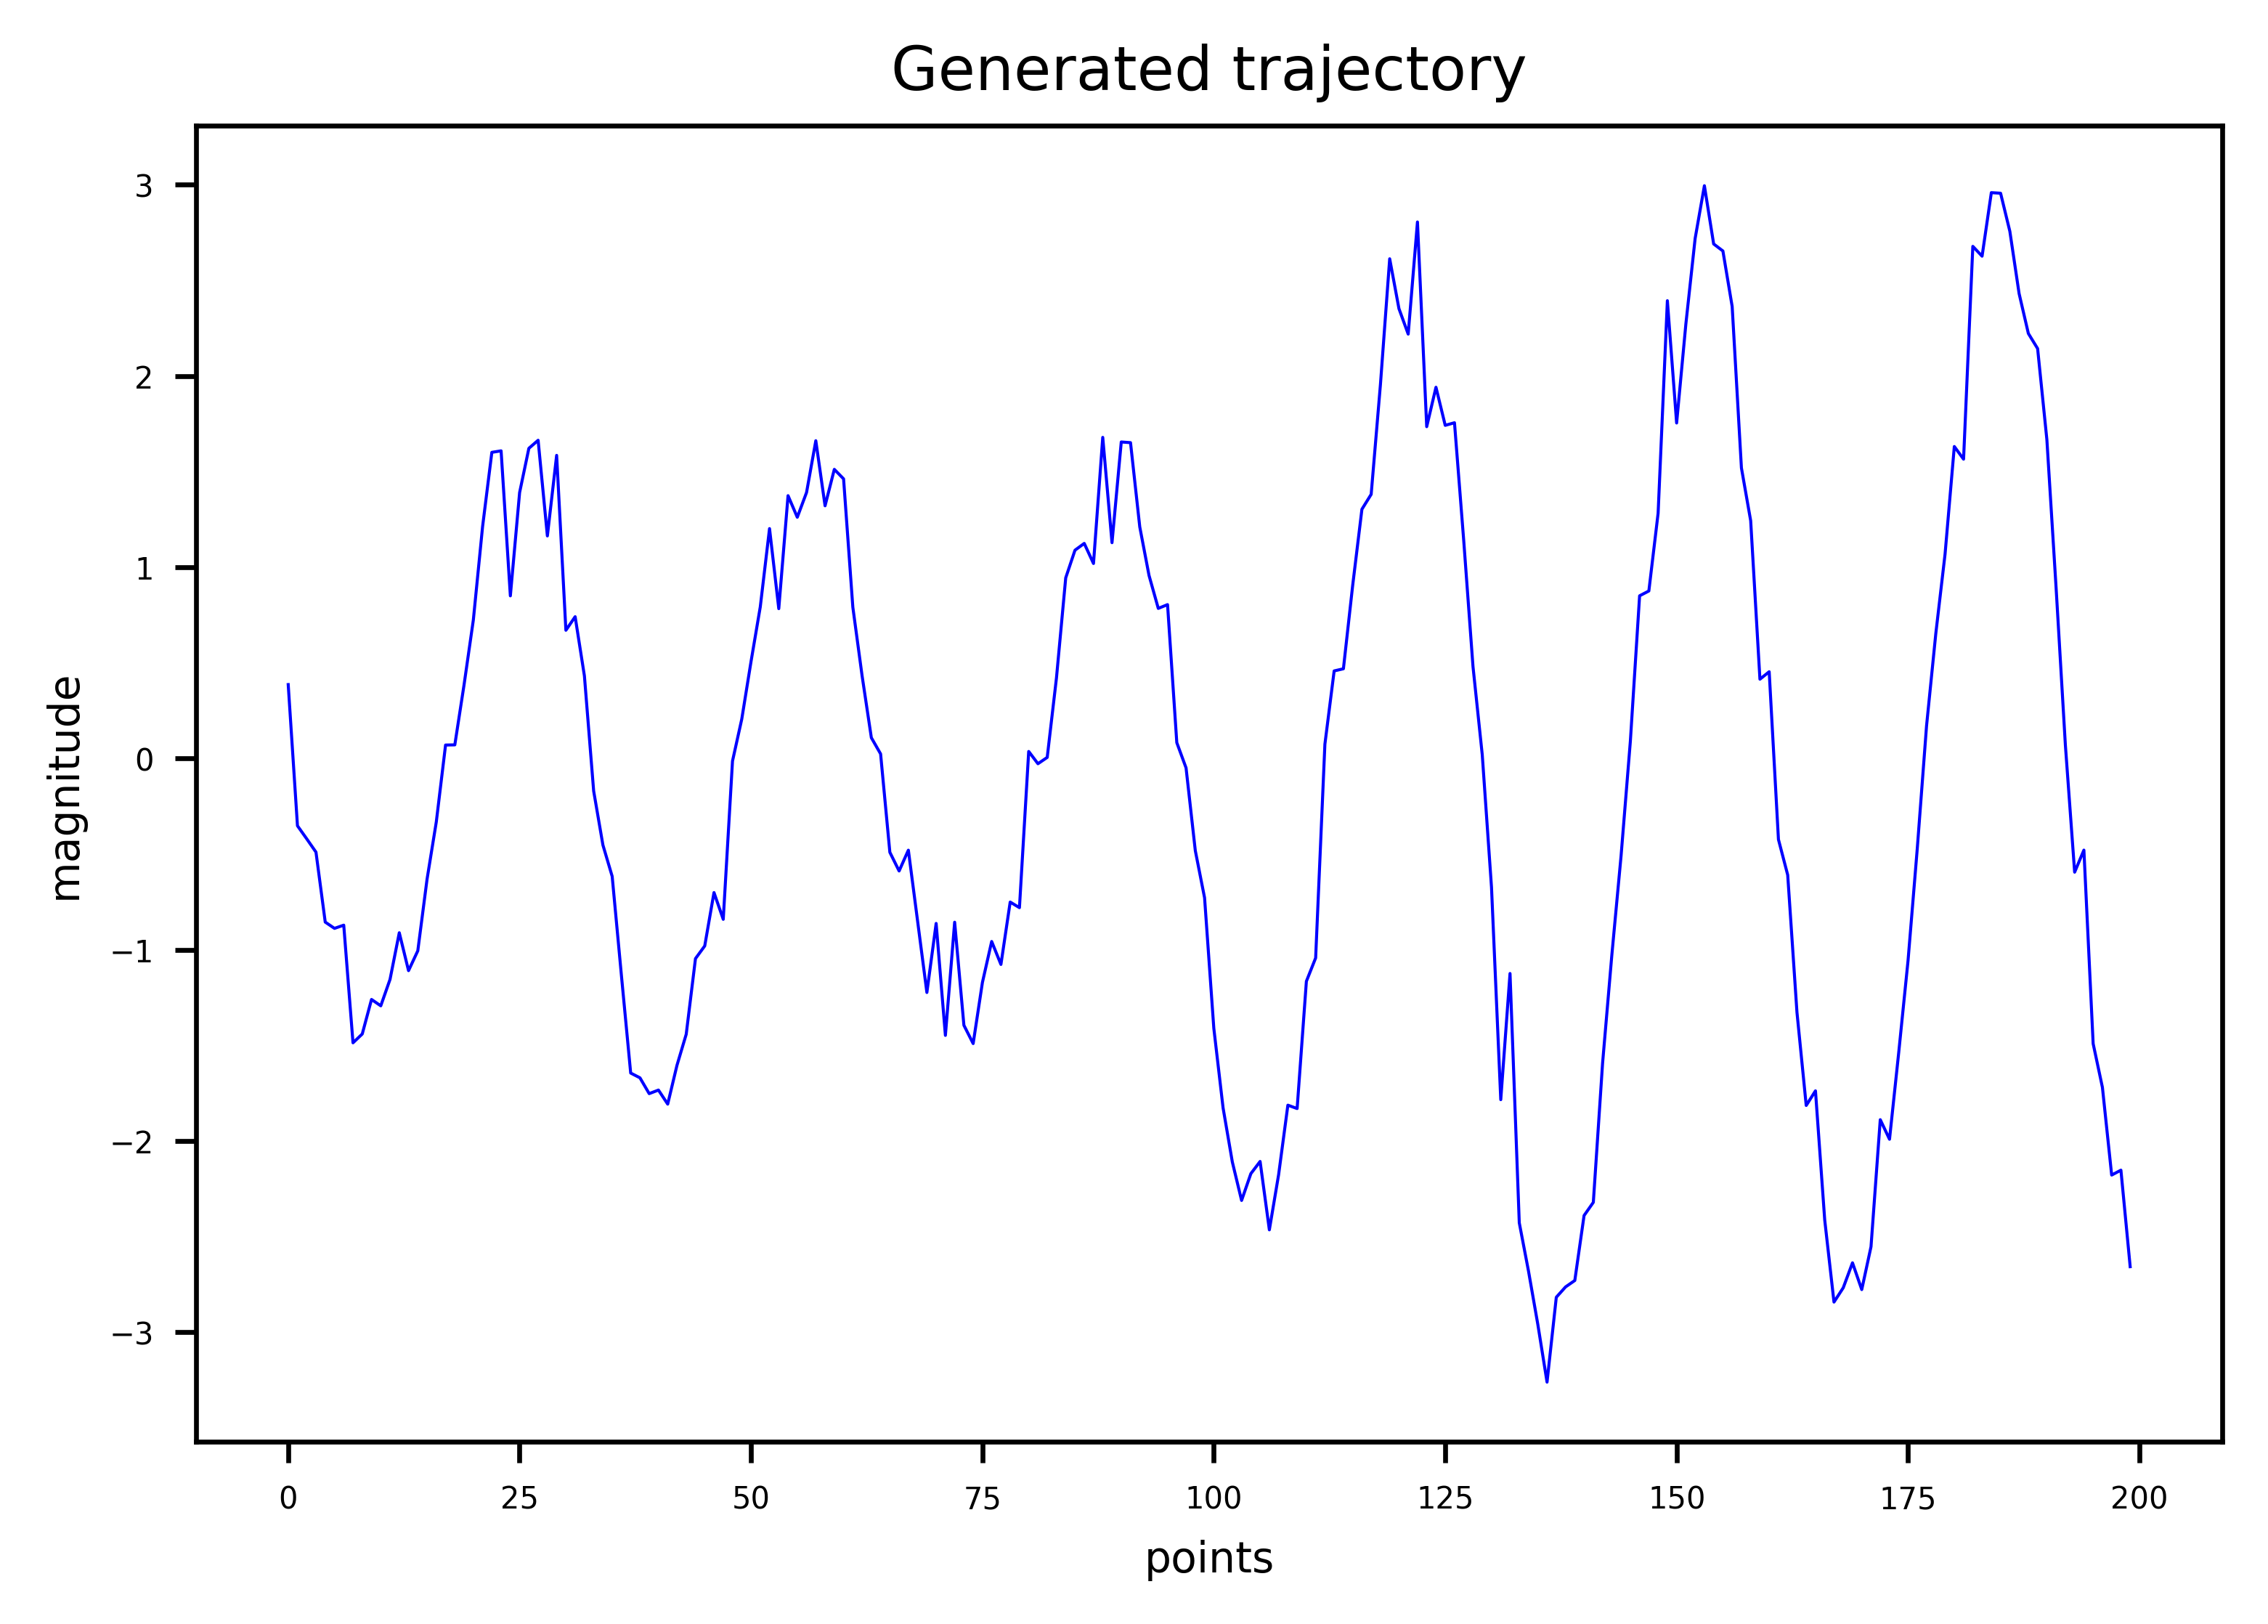

In [161]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
# ax.plot(range(N),x,'g', label = 'X', linewidth = 0.5 )
ax.plot(range(N),z,'b', label = 'z', linewidth = 0.5 )
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

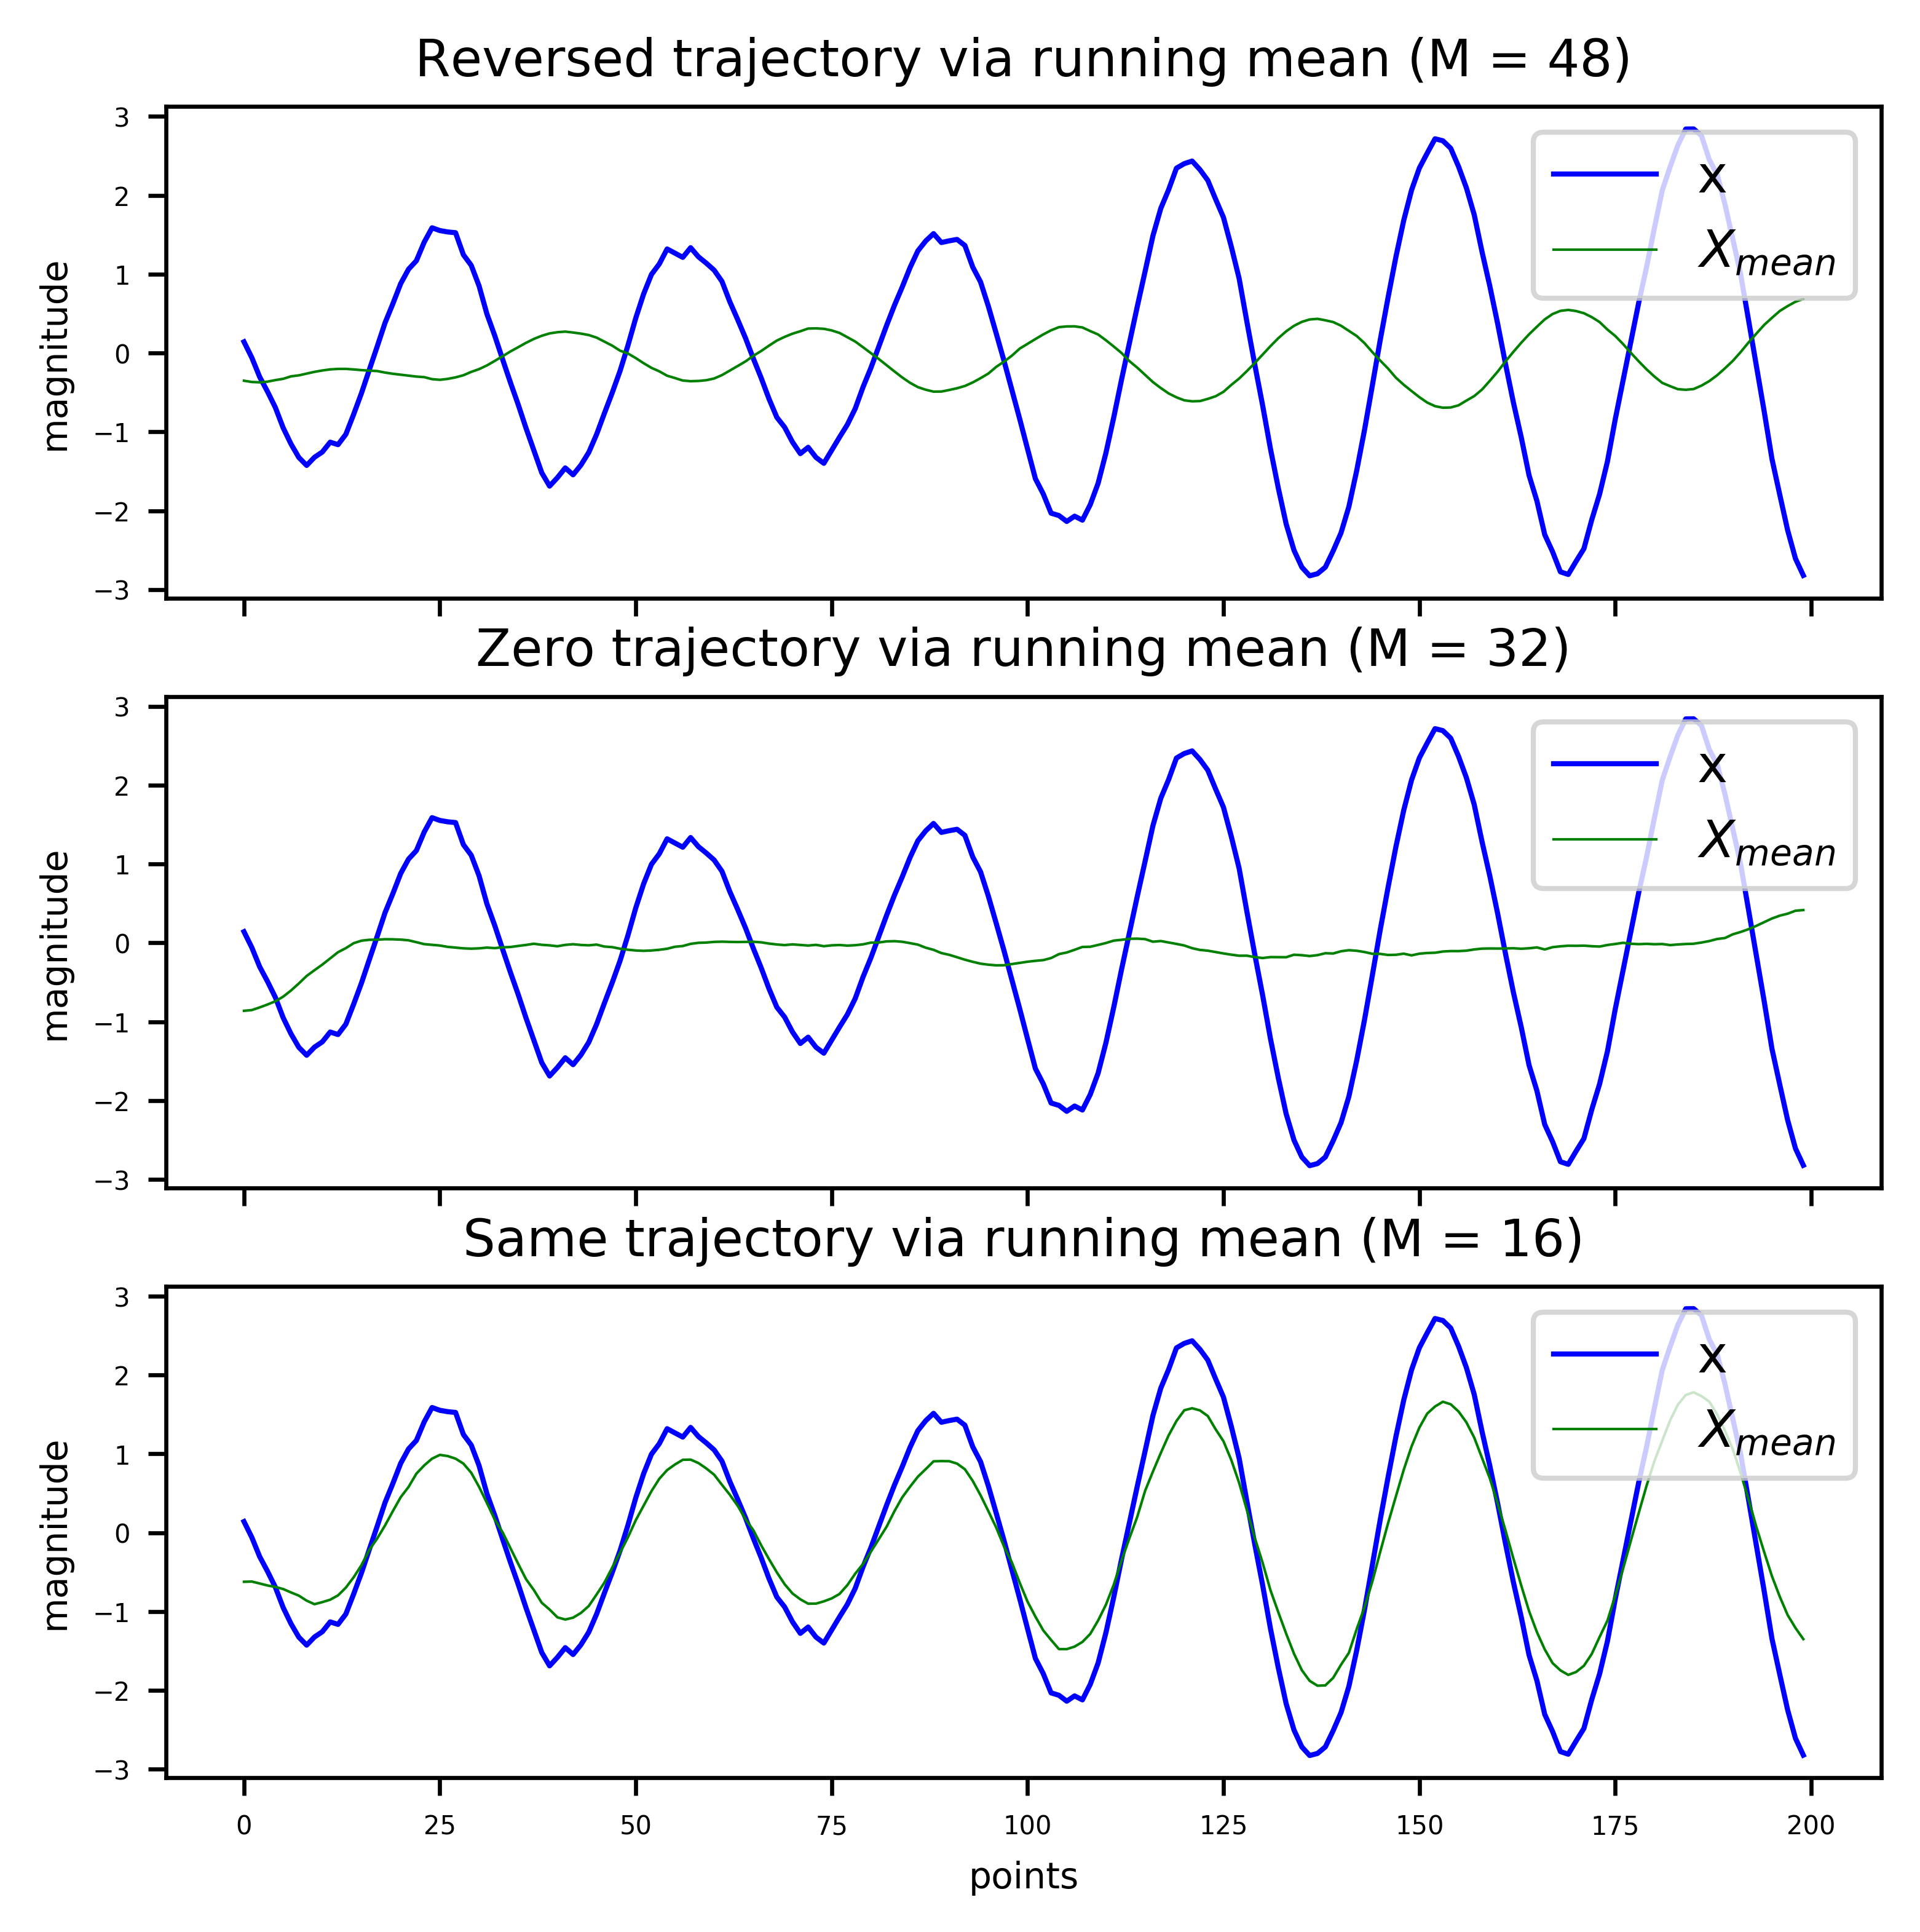

In [167]:

fig, ax = plt.subplots(3,1, figsize=(6,6), dpi = 600, sharex = True)
M = 48
ax[0].set_title('Reversed trajectory via running mean (M = %d)' % (M), fontsize = 10)
ax[0].plot(range(N), x,'b', label = 'x', linewidth = 1)
ax[0].plot(range(N), running_mean(z, M),'g', label = r'$X_{mean}$', linewidth = 0.5)
ax[0].set_ylabel('magnitude', fontsize = 7)
ax[0].legend(loc="upper right", fontsize=10)

M = 32
ax[1].set_title('Zero trajectory via running mean (M = %d)' % (M), fontsize = 10)
ax[1].plot(range(N), x,'b', label = 'x', linewidth = 1)
ax[1].plot(range(N), running_mean(z, M),'g', label = r'$X_{mean}$', linewidth = 0.5)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].legend(loc="upper right", fontsize=10)

M = 16
ax[2].set_title('Same trajectory via running mean (M = %d)' % (M), fontsize = 10)
ax[2].plot(range(N), x,'b', label = 'x', linewidth = 1)
ax[2].plot(range(N), running_mean(z, M),'g', label = r'$X_{mean}$', linewidth = 0.5)
ax[2].set_ylabel('magnitude', fontsize = 7)
ax[2].set_xlabel('points', fontsize = 7)
ax[2].legend(loc="upper right", fontsize=10);

# Today we learn drawback exp mean and running mean